# Assignment 2 - part 1

## Feed forward network (multilayer perceptron)

In this assignment you shall develop the complete training and evaluation pipeline for a fully connected feed forward network.
This shall cover all the stages discussed in the course, starting from data preparation and finishing with model evaluation.
You can (you should) use the full functionality of PyTorch and all its packages.

You can write most of your code as standard python scripts and packages outside jupyter notebook.
The calls to the functionality shall, however, be executed from this notebook (not command-line).
All printouts images and comments should be displayed in this notebook.

You shall use this framework to train (at least) 3 feed-forward neural networks and compare their performance:
- first, use only linear layers and non-linearites of your choice. You shall decide on the depth and width of the layers as well as all other hyperparameters as you see fit.
- second, use linear layers, non-linearities and drop-out
- third, use linear layers, non-linearities,  drop-out and batch norm


### Model training and evaluation

Define the function `mlp_train` for training and evaluating an MLP model for classification of **FashionMNIST** data.
The function shall be flexible so that it can take in all necessary hyper-parameters for the training. You shall not fix the hyper-parameters in the code of the function itself as fixed values.

The `mlp_train` function shall return 
* the trained model `mlp_model`
* anything else you deem important or useful for monitoring purposes etc. 

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Define a transformation to normalize the dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])

# Download and load the training data
trainset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data/", download=True, train=True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data/", download=True, train=False, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

### Create 3 models.
use input_size, hidden_sizes and output_size as parameters. create 3 layers (input, hidden, output):
- 1 Model: linear, relu;
- 2 Model: linear, relu, dropout;
- 3 Model: linear, relu, dropout, BatchNorm1d.

In [4]:
input_size = 784                # each image is 28x28 which is a total of 784 pixels
hidden_sizes = [256, 64]        # I tried some other combinations like [256, 128], [128, 64], [512,128], [512,64], but the best accuracy I get only with [256,64]
output_size = 10                # there are 10 classes
epochs = 35                   # 35 - optimal to get maximum accuracy. after 15 epochs accuracy doesn`t chanche much, so to decrease run time I choose 17 epochs

In [5]:
# Model 1:

class Model1(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)
        
        self.relu=nn.ReLU()
        
    def forward(self, x):
        # Flatten the input tensor
        x = x.view(x.shape[0], -1)    
     
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)           # use log_softmax directly (not log(softmax))

        return x
    
model1 = Model1(input_size, hidden_sizes, output_size)
loss_func = nn.CrossEntropyLoss()                       # use nn.CrossEntropyLoss (not nn.NLLLoss)
optimizer1 = optim.Adam(model1.parameters(), lr=0.003)  # use Adam (not SGD)

In [6]:
print(model1)

Model1(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)


In [7]:
# Model 2:

class Model2(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)
        
        # Dropout module with a 0.2 drop probability 
        self.drop = nn.Dropout(p=0.2)
        self.relu=nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)    
        # Set the activation functions
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = F.log_softmax(self.fc3(x), dim=1)
    
    
        return x
    
model2 = Model2(input_size, hidden_sizes, output_size)

optimizer2 = optim.Adam(model2.parameters(), lr=0.003)

In [8]:
print(model2)

Model2(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)


In [9]:
# Model 3:

class Model3(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()
        inter_features=2*input_size
        self.fc1 = nn.Linear(input_size, inter_features)
        self.fc2 = nn.Linear(inter_features, inter_features)
        self.fc3 = nn.Linear(inter_features, output_size)
        
        # Dropout module with a 0.2 drop probability 
        self.drop = nn.Dropout(p=0.2)
        self.relu=nn.ReLU()
        self.batchnorm1=nn.BatchNorm1d(inter_features)
        self.batchnorm2=nn.BatchNorm1d(inter_features)
        
    def forward(self, x):
        # Flatten the input tensor
        x = x.view(x.shape[0], -1)    
     
        x = self.drop(F.relu(self.fc1(x)))
        x=self.batchnorm1(x)
        x = self.drop(F.relu(self.fc2(x)))
        x=self.batchnorm2(x)
        x = F.log_softmax(self.fc3(x), dim=1)

        return x
    
model3 = Model3(input_size, hidden_sizes, output_size)
optimizer3 = optim.Adam(model3.parameters(), lr=0.003)

In [10]:
print(model3)

Model3(
  (fc1): Linear(in_features=784, out_features=1568, bias=True)
  (fc2): Linear(in_features=1568, out_features=1568, bias=True)
  (fc3): Linear(in_features=1568, out_features=10, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (batchnorm1): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


### Model application

Define a simple utility function `mlp_apply` that uses the train model to classify 10 examples of the test set and displays the 10 images in a grid together with their true and predicted labels.

Model 1:


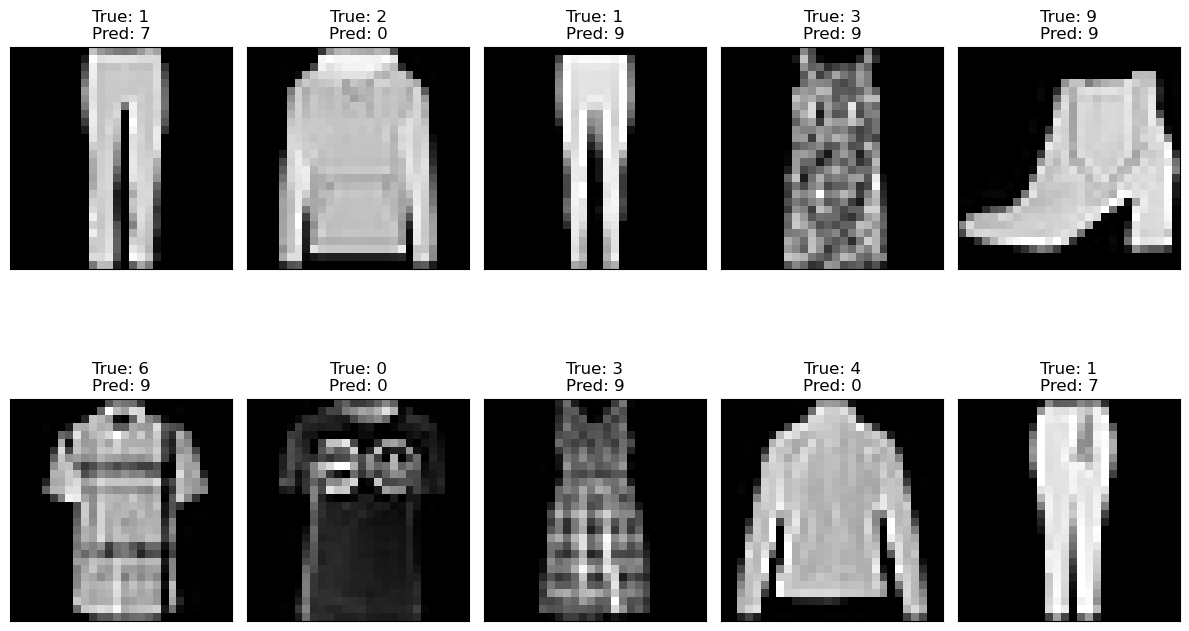

In [11]:
def mlp_apply(model, test_loader):
    output =[]
    pred=[]
    examples = enumerate(test_loader)
    batch_idx, (example_data, example_targets) = next(examples)
    
    with torch.no_grad():
        output = model(example_data)
    
    pred = output.argmax(dim=1, keepdim=True)
    
    # Plotting the results
    plt.figure(figsize=(12, 8))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
        plt.title(f"True: {example_targets[i].item()}\nPred: {pred[i].item()}")
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()
    
    

print("Model 1:")
mlp_apply(model1, testloader)
print("Model 2:")
mlp_apply(model2, testloader)
print("Model 3:")
mlp_apply(model3, testloader)


### Train and apply model

Use your functions defined above to train the three models. Try different values of the hyper-paramter settings. You shall achieve at least 80% test accuracy with all your models and at least 90% test accuracy with the best one.

Describe briefly your three models and your hyper-parameter setups and comment your results.

**Compare the performance of the three models using suitable supportive tables and graphs, and complemented by relevant comments.**

In [12]:
  
def train (model, trainloader, optimizer):

    # ep_losses = []
    # ep_accuracy = []

    # for epoch  in range(epochs):
    #     batch_losses = []
    #     batch_accuracy = []
    #     for x_batch, y_batch in trainloader:
    #         model.train()
    #         logits = model(x_batch) # forward
    #         loss = loss_func(logits, y_batch)            # loss calculation
    #         _,preds=torch.max(logits,1)
    #         accuracy=torch.sum(preds==y_batch) / len(preds) # monitoring
    #         batch_losses.append(loss.item())
    #         batch_accuracy.append(accuracy.item())
    #         loss.backward()   # backward - get gradients
    #         optimizer.step()
    #         optimizer.zero_grad()             
    #     avg_loss = sum(batch_losses)/len(batch_losses)
    #     avg_acc = sum(batch_accuracy)/ len(batch_accuracy)
    #     print(f'Epoch {epoch}: loss is {avg_loss} acc is {avg_acc}')
    #     ep_losses.append(avg_acc)
    #     ep_accuracy.append(avg_acc)
    
    train_losses, test_losses = [], []

    for e in range(epochs):
        tot_train_loss = 0 
        for images, labels in trainloader:
            log_ps = model(images)
            loss = loss_func(log_ps, labels)
            
            optimizer.zero_grad()                   # zero out gradients
            loss.backward()
            optimizer.step()
            
            tot_train_loss += loss.item()
        else:
            tot_test_loss = 0
            test_correct = 0
            # Turn off gradients for validation to save memory and speed up computations
            with torch.no_grad():
                model.eval()
                for images, labels in testloader:
                    log_ps = model(images)
                    loss = loss_func(log_ps, labels)
                    tot_test_loss += loss.item()
                    
                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    test_correct += equals.sum().item()
                    
            model.train()
            
            # Get mean loss to enable comparison between train and test sets
            train_loss = tot_train_loss / len(trainloader.dataset)
            test_loss = tot_test_loss / len(testloader.dataset)
            
            # At completion of epoch
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            
            # if e % 2==0:                                   
            print("Epoch: {}/{}.. ".format(e+1, epochs),
            "Training Loss {:.3f}.. ".format(train_loss),
            "Test Loss {:.3f}.. ".format(test_loss),
            "Test Accuracy {:.3f}".format(test_correct / len(testloader.dataset)))




In [13]:
print("Model 1:")   
train(model1, trainloader, optimizer1)

Model 1:


KeyboardInterrupt: 

In [ ]:
print("Model 2:")   
train(model2, trainloader, optimizer2)


In [14]:
print("Model 3:")   
train(model3, trainloader, optimizer3)

Model 3:
Epoch: 1/35..  Training Loss 0.010..  Test Loss 0.015..  Test Accuracy 0.810
Epoch: 2/35..  Training Loss 0.008..  Test Loss 0.176..  Test Accuracy 0.831
Epoch: 3/35..  Training Loss 0.007..  Test Loss 0.440..  Test Accuracy 0.832
Epoch: 4/35..  Training Loss 0.006..  Test Loss 1.464..  Test Accuracy 0.834
Epoch: 5/35..  Training Loss 0.006..  Test Loss 0.600..  Test Accuracy 0.853
Epoch: 6/35..  Training Loss 0.006..  Test Loss 0.885..  Test Accuracy 0.863
Epoch: 7/35..  Training Loss 0.006..  Test Loss 1.554..  Test Accuracy 0.848
Epoch: 8/35..  Training Loss 0.006..  Test Loss 0.841..  Test Accuracy 0.860
Epoch: 9/35..  Training Loss 0.005..  Test Loss 0.145..  Test Accuracy 0.859
Epoch: 10/35..  Training Loss 0.005..  Test Loss 0.231..  Test Accuracy 0.863
Epoch: 11/35..  Training Loss 0.005..  Test Loss 0.195..  Test Accuracy 0.873
Epoch: 12/35..  Training Loss 0.005..  Test Loss 0.227..  Test Accuracy 0.872
Epoch: 13/35..  Training Loss 0.005..  Test Loss 0.396..  Test A

Best accuracy using 35 epochs:
- Model 1: 88.5% - the fastest - reach 88.5% by about 15 epoch;
- Model 2: 88.3% - slower - reach 88.3 % by about 27 epoch;
- Model 3: 88.6% - reach 88.6% by about 33 epoch.

I tried different hyperparameters, but these work better. I didn`t try more than 35 epochs, becouse it takes too much time (for example, running the 3d model took more than one hour).

# OUTPUTS (with 35 epochs):
1. Model 1:





2. Model 2:





3. Model 3:
- Epoch: 1/35..  Training Loss 0.010..  Test Loss 0.015..  Test Accuracy 0.810
- Epoch: 2/35..  Training Loss 0.008..  Test Loss 0.176..  Test Accuracy 0.831
- Epoch: 3/35..  Training Loss 0.007..  Test Loss 0.440..  Test Accuracy 0.832
- Epoch: 4/35..  Training Loss 0.006..  Test Loss 1.464..  Test Accuracy 0.834
- Epoch: 5/35..  Training Loss 0.006..  Test Loss 0.600..  Test Accuracy 0.853
- Epoch: 6/35..  Training Loss 0.006..  Test Loss 0.885..  Test Accuracy 0.863
- Epoch: 7/35..  Training Loss 0.006..  Test Loss 1.554..  Test Accuracy 0.848
- Epoch: 8/35..  Training Loss 0.006..  Test Loss 0.841..  Test Accuracy 0.860
- Epoch: 9/35..  Training Loss 0.005..  Test Loss 0.145..  Test Accuracy 0.859
- Epoch: 10/35..  Training Loss 0.005..  Test Loss 0.231..  Test Accuracy 0.863
- Epoch: 11/35..  Training Loss 0.005..  Test Loss 0.195..  Test Accuracy 0.873
- Epoch: 12/35..  Training Loss 0.005..  Test Loss 0.227..  Test Accuracy 0.872
- Epoch: 13/35..  Training Loss 0.005..  Test Loss 0.396..  Test Accuracy 0.876
- Epoch: 14/35..  Training Loss 0.005..  Test Loss 0.742..  Test Accuracy 0.867
- Epoch: 15/35..  Training Loss 0.005..  Test Loss 2.371..  Test Accuracy 0.812
- Epoch: 16/35..  Training Loss 0.005..  Test Loss 0.715..  Test Accuracy 0.871
- Epoch: 17/35..  Training Loss 0.005..  Test Loss 5.421..  Test Accuracy 0.856
- Epoch: 18/35..  Training Loss 0.005..  Test Loss 0.706..  Test Accuracy 0.871
- Epoch: 19/35..  Training Loss 0.005..  Test Loss 0.343..  Test Accuracy 0.864
- Epoch: 20/35..  Training Loss 0.005..  Test Loss 0.375..  Test Accuracy 0.880
- Epoch: 21/35..  Training Loss 0.005..  Test Loss 0.141..  Test Accuracy 0.884
- Epoch: 22/35..  Training Loss 0.005..  Test Loss 0.754..  Test Accuracy 0.878
- Epoch: 23/35..  Training Loss 0.004..  Test Loss 0.241..  Test Accuracy 0.879
- Epoch: 24/35..  Training Loss 0.004..  Test Loss 0.044..  Test Accuracy 0.880
- Epoch: 25/35..  Training Loss 0.004..  Test Loss 0.439..  Test Accuracy 0.880
- Epoch: 26/35..  Training Loss 0.004..  Test Loss 0.151..  Test Accuracy 0.879
- Epoch: 27/35..  Training Loss 0.004..  Test Loss 0.057..  Test Accuracy 0.884
- Epoch: 28/35..  Training Loss 0.004..  Test Loss 0.149..  Test Accuracy 0.880
- Epoch: 29/35..  Training Loss 0.004..  Test Loss 0.177..  Test Accuracy 0.881
- Epoch: 30/35..  Training Loss 0.004..  Test Loss 0.286..  Test Accuracy 0.884
- Epoch: 31/35..  Training Loss 0.004..  Test Loss 2.864..  Test Accuracy 0.883
- Epoch: 32/35..  Training Loss 0.004..  Test Loss 0.041..  Test Accuracy 0.884
- Epoch: 33/35..  Training Loss 0.004..  Test Loss 0.045..  Test Accuracy 0.886
- Epoch: 34/35..  Training Loss 0.004..  Test Loss 0.067..  Test Accuracy 0.885
- Epoch: 35/35..  Training Loss 0.004..  Test Loss 0.038..  Test Accuracy 0.883